# DryWetLab
This notebook contains a variety of experiments using the simulated organoids and test equipment from the library `drywetlab.py`.

### Table of Contents:
1. **BRAAAAAAINS** | Generate and sanity-check an Organoid object
1. **Tests** | Several different (independent) tests you can run:
1. **Bibliography** | Plus a couple annotations.

In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib as mpl
mpl.rc("text", usetex=True)
mpl.rc("text.latex", preamble="\\usepackage{amsmath}")
mpl.rc("font", family="serif")
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import requests, json

import os
os.environ.putenv('S3_ENDPOINT', 's3.nautilus.optiputer.net')

import tensorflow as tf
tf.enable_eager_execution()

/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# BRAAAAAAINS
Create an Organoid object representing 1000 cortical neurons at uniformly random locations in the region of interest. The scale of the physical position is calculated from a number given by Collins (2016) for the areal density of cells in chimpanzee neocortex: about 20 million cells per square centimeter of cortical surface. That means 1000 cells exist in an area 70$\mu m$ on a side.

The neuron parameters are of course adapted from Izhikevich's work, a combination of the approach from the 2003 paper (whose demonstration is reproduced here) with the data from _Dynamical Systems in Neuroscience_. Two different versions of the model are used in these two sources, and although they are obviously topologically conjugate, they are not algebraically equivalent for any set of parameter values. Combined with the sensitivity of the behavior of both models to the exact values of the parameters, this has meant that I have not been able to reproduce the clear $\alpha$ and $\gamma$ rhythms of the original demonstration. Additionally, it seems the more biophysically accurate model is even easier to drive into what amounts to epilepsy: perhaps the scale on the recovery variable $u$ is smaller here?

The synaptic weight matrix entries $S_{ij}$ are distributed according to Song (2005), who described measurements of EPSPs in layer-V pyramidal cells in rat V1. The result was that EPSP strength is lognormally distributed (they gave parameters, which are reproduced below) and does not depend substantially on distance within the range of about 50um that thye tested. Values sampled from their distribution are converted from mV EPSPs to pA EPSCs by multiplying by a typical value of $C\over\tau$ (the membrane capacitance divided by the EPSC decay time constant); this can be derived by integrating the effect of the EPSC on the membrane voltage in the absence of leakage and setting it equal to the desired EPSP value.

Song (2005) measured only *E*PSPs, but I need to consider inhibitory cells as well in order to have any hope of reproducing the dynamics of real neurons. Here, I make the certainly-false assumption that inhibitory cells have the same distribution. In fact, since inhibitory neurons are typically local interneurons, the distribution of IPSP strength should be expected to depend on distance, but I have no data on this yet. Additionally, I assume that inhibitory cells are twice as strong as excitatory cells to make up for their lesser numbers.

The latter assumption has some basis in fact, but the mechanism and number are completely fabricated. In the real brain, both shunt and series inhibition occur; whereas series inhibition behaves like excitation, shunt inhibition increases the local leakage to prevent EPSPs from moving past a certain point in the dendrite. This means that in addition to having a different concept of strength, shunt inhibition requires at least some form of dendritic modeling, so it has been ignored for now.

Finally, the model is completely deterministic except for an input $I_{\text{th}}$ from background thalamic activity. Since we have no way to model this, we assume it is Gaussian with no time-dependence, and all $N$ of these currents are independent of each other. Trial and error yielded values which give apparently-sane results in Izhikevich's demos: each has mean zero, but the input to excitatory cells is 1.5x larger than the input to inhibitory cells in order to create the correct balance between their firing rates.

A handwavey biological argument in favor of this approach is.....

In [ ]:
import drywetlab

# Number of neurons, followed by the number which are excitatory.
N = 1000
Ne = 800

# Used for constructing nonhomogeneous neural populations,
# interpolated between two types based on the value of
# r ∈ [0,1]. Excitatory neurons go from Regular Spiking
# to Chattering, while inhibitory neurons go from
# Low-Threshold Spiking to Late Spiking models over the
# same range. Adapted from Izhikevich's writings.
r = np.random.rand(N) # unitless
l = np.ones(N) # unitless

# a : 1/ms recovery time constant of membrane leak currents
a = np.hstack((0.03*l[:Ne], 0.03 + 0.14*r[Ne:]))
# b : nS recovery conductivity
b = np.hstack((-2*l[:Ne] + 3*r[:Ne]**2, 8 - 3*r[Ne:]))
# c : mV voltage of the downstroke
c = np.hstack((-50 + 10*r[:Ne]**2, -53 + 8*r[Ne:]))
# d : pA instantaneous increase in leakage during downstroke
d = np.hstack((100 + 50*r[:Ne]**2, 20 + 80*r[Ne:]))
# C : pF membrane capacitance
C = np.hstack((100 - 50*r[:Ne]**2, 100 - 80*r[Ne:]))
# k : nS/mV Na+ voltage-gated channel conductivity parameter
k = np.hstack((0.7 + 0.8*r[:Ne]**2, 1 - 0.7*r[Ne:]))
# mV : resting membrane voltage
Vr = np.hstack((-60*l[:Ne], -56 - 10*r[Ne:]))
# mV : threshold voltage at u=0
Vt = np.hstack((-40*l[:Ne], -42 + 2*r[Ne:]))

# tau : ms time constant of synaptic current
tau = 3

# Sij : pA total EPSC generated in neuron i when neuron j fires.
mu, sigma = -0.702, 0.9355
S = np.random.lognormal(mean=mu, sigma=sigma, size=(N,N))
S *= np.median(C / tau)
S[:,Ne:] *= -2

excitatory = np.arange(N) < Ne
inhibitory = np.arange(N) >= Ne

# XY : um planar positions of the cells
XY = np.random.rand(2,N) * 70

# Dimensionality reduction: make the cell index n 
# represent position as well as possible (which 
# is not really very well...but it may help)
import sklearn.manifold
embedding = sklearn.manifold.MDS(1)
indices = np.argsort(embedding.fit_transform(XY.T).flatten())
permute = np.eye(N)[indices,:]

# Apply the generated permutation.
XY = XY[:, indices]
S = permute @ S @ permute
excitatory = excitatory[indices]
inhibitory = inhibitory[indices]

# Create the actual Organoid object
n = drywetlab.Organoid(XY=XY, S=S, tau=tau,
                       a=a, b=b, c=c, d=d, k=k, C=C, Vr=Vr, Vt=Vt)

# Ith : ms -> pA random input current from the thalamus
def Ith(t):
    return np.hstack((1.5*np.random.randn(Ne), np.random.randn(N-Ne))) * 200


# Sanity check 1: histogram plus a few stats on S.
plt.figure()
plt.hist(np.log(S[S>0]).flatten() / np.log(10), 50,
         normed=False, facecolor='g', alpha=0.75, log=True)
plt.hist(np.log(-S[S<0]).flatten() / np.log(10), 50,
         normed=False, facecolor='b', alpha=0.75, log=True)
plt.legend(('EPSC', 'IPSC'))
plt.title('Histogram of peak postsynpatic current')
plt.xlabel('$\log_{10} s_{ij}$')
plt.ylabel('Counts')


print('Mean peak EPSC:', np.mean(S[S>0]))
print('Median peak EPSC:', np.median(S[S>0]))
print('Max peak EPSC:', S.max())
print()
print('Mean peak IPSC:', -np.mean(S[S<0]))
print('Median peak IPSC:', -np.median(S[S<0]))
print('Max peak IPSC:', -S.min())


### Reproduce Izhikevich (2003)'s demo.

In [ ]:
firings = []
for t in range(1001):
    _, fired = n.step(Ith(t))
    for i in range(N):
        if fired[i]:
            firings.append((t,i))

firings = np.array(firings)
firinge = excitatory[firings[:,1]]
firingi = inhibitory[firings[:,1]]
plt.figure()
plt.plot(firings[firinge,0], firings[firinge,1], '.', markersize=1)
plt.plot(firings[firingi,0], firings[firingi,1], '.', markersize=1)
plt.title('Neuron firings over time')
plt.xlabel('Time $t$ (ms)')
plt.ylabel('Neuron index') and None

### Create the peripherals

In [ ]:
n.reset()

# Create eight probe points evenly spaced around a circle of radius 30um
n_probes = 8
theta = np.linspace(0, 2*np.pi, num=n_probes+1)[:-1]
points = np.array([np.cos(theta), np.sin(theta)]) * 30 + 35
u = drywetlab.UtahArray(#spacing=10, shape=(7,7), offset=(5,5),
                        points=points, activation=None)
u.insert(n)

interval = 100
cam = drywetlab.Ca2tCamera(n, Iin=None, frameskip=interval - 1,
                           window_size=11, reactivity=40)

# Tests
Here are a bunch of different tests you can run. They should all be completely independent, so that if one doesn't work without running a different one, that is a bug.

1. **MEA Recording** | Display the Organoid's response to probing.
1. **Ca2+ Imaging** | Generate a dataset of Ca2+ still images.
1. **Timeseries** | Generate a dataset of binary timeseries.

## MEA Recording
Display a movie of the organoid generated above as the probe stimulation point goes through each of the possible options, _and_ record the readings from a MEA during that time.

In [ ]:
animation_filename = None

def activation(t):
    probe = int((t % real_time) / (stim_time / 2))
    probe = probe//2 if probe % 2 == 0 else -1
    return 100 * (np.arange(0,ushape) == probe)
u.activation = activation

def tick(t, *args):
    states[t,:] = u.Vprobe()
cam.tick = tick

def Iin(t):
    return 225*np.random.randn(N) + u.Iout(t)
cam.Iin = Iin

fig = plt.figure()
cam.init(fig)

ushape = u.points.shape[1]
stim_time = 1000
real_time = ushape * stim_time
frames = real_time // interval
states = np.zeros((real_time, ushape))
ani = animation.FuncAnimation(fig, func=cam.update,
                              interval=interval, frames=frames, save_count=frames)
if animation_filename is not None:
    ani.save(filename=animation_filename, writer='ffmpeg', dpi=300)

Plotting the measured average membrane voltage at each point over time, correlations are visible, if you apply a low-pass filter and squint. An interesting feature of this graph is that certain regions of the organoid obviously stay active for a decent amount of time even after the input stops, while others are quiescent pretty much instantly. The time it takes for output to become visible also varies. From this plot, it should be ridiculously obvious that ML will be able to see correlations in at least some version of my output data.

In [ ]:
# Average over each second of activity.
n_mean = 100
states1 = np.cumsum(states, axis=0)
states1 = (states1[n_mean:,:] - states1[:-n_mean,:])[:-1] / n_mean

plt.figure()
plt.imshow(states1.T, aspect='auto', extent=(0, real_time/1000, 7.5, -0.5))
plt.xlabel('Time (s)')
plt.ylabel('Probe Index')
plt.title('Probed Responses to Moving Stimulus')
print(states1.min(), states1.max())

## Ca2+ Imaging
Take the same organoid, MEA, and camera as above, and generate a pile of different images in a training image directory. For future reference, the ImageMagick crop command is

    convert $< -crop 460x350+95+70 $@

In [ ]:
t_stop = 1000  # Time to end stimulation
t_snap = 1100  # Time to take the picture: will be floored to 100ms units.
dataset_prefix = None

def Iin(t):
    return 225*np.random.randn(N) + u.Iout(t)
cam.Iin = Iin

cam.init()
# Modify this range to decide which dataset indices are generated.
for i in range(0,1):
    u_width = u.points.shape[1]
    pattern = np.random.randint(u_width)
    u.activation = lambda t: 100 * ((np.arange(u_width) == pattern) & (t <= t_stop))

    n.reset()

    for T in range(t_snap // interval - 1):
        cam.update(T, show=False)
    cam.update(T, show=True)

    if dataset_prefix is None:
        plt.title('Response to input {}'.format(pattern))
    else:
        plt.savefig(dataset_prefix + '_{:04d}_{}.png'.format(i, pattern))


## Timeseries
Using the same test setup as above, rather than saving a Ca2+ image, just save a binary timeseries of which cells fired between $t_{\text{stop}}$ and $t_{\text{snap}}$; these will go into a single <tt>tfrecord</tt> file rather than a whole folder of PNGs.

In [ ]:
t_stop = 1000
t_snap = 1100

Npoints_train = 8000
Npoints_test = 2000
dataset_train = 'data/train.tfrecord'
dataset_test = 'data/test.tfrecord'
metadata_file = 'data/metadata.json'

In [ ]:
# This just draws a loop progress bar. If you don't want it,
# replace the import with the following:
# tqdm = lambda: None; tqdm.tqdm = lambda x: x
import tqdm

def Iin(t):
    return 225*np.random.randn(N) + u.Iout(t)

def write_data(dataset, Npoints):
    with tf.python_io.TFRecordWriter(dataset) as writer:
        for i in tqdm.tqdm(range(Npoints)):
            u_width = u.points.shape[1]
            pattern = np.random.randint(u_width)
            u.activation = lambda t: 100 * ((np.arange(u_width) == pattern) & (t <= t_stop))

            n.reset()
            firings = np.zeros((t_snap - t_stop, N), dtype=np.bool)
            # Simulate with stimulation until t_stop.
            for t in range(t_stop):
                n.step(Iin(t))
            # Then simulate without stimulation and save firing rates.
            for t in range(t, t_snap):
                _, fired = n.step(Iin(t))
                firings[t - t_stop, fired] = True

            bits = bytes(np.packbits(firings))

            writer.write(tf.train.Example(features=tf.train.Features(feature = {
                'example': tf.train.Feature(bytes_list=tf.train.BytesList(value=[bits])),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[int(pattern)]))
            })).SerializeToString())
            
write_data(dataset_train, Npoints_train)
write_data(dataset_test, Npoints_test)

In [ ]:
# Remember which version of the code generated this data.
commit_id = !git log | head -1
commit_id = commit_id[0].split()[1]

# Also pickle the organoid.
import pickle
pickle_file = 'data/brain.pkl'
with open(pickle_file, 'wb') as f:
    pickle.dump(n, f)

# Save this all in metadata.
with open(metadata_file, 'w') as f:
    f.write(json.dumps({
        "dataset": "timeseries",
        "description": "Timeseries of firing",
        "labels": list(range(n_probes)),
        "train_examples_name": dataset_train,
        "test_examples_name": dataset_test,
        "num_train_examples": Npoints_train,
        "num_test_examples": Npoints_test,
        'number_of_cells': N,
        'recording_time': t_snap - t_stop,
        'commit_id': commit_id,
        'organoid': pickle_file
    }))

In [6]:
!aws s3 --endpoint https://$S3_ENDPOINT ls braingeneers/

Unable to locate credentials. You can configure credentials by running "aws configure".


<IPython.core.display.Javascript object>


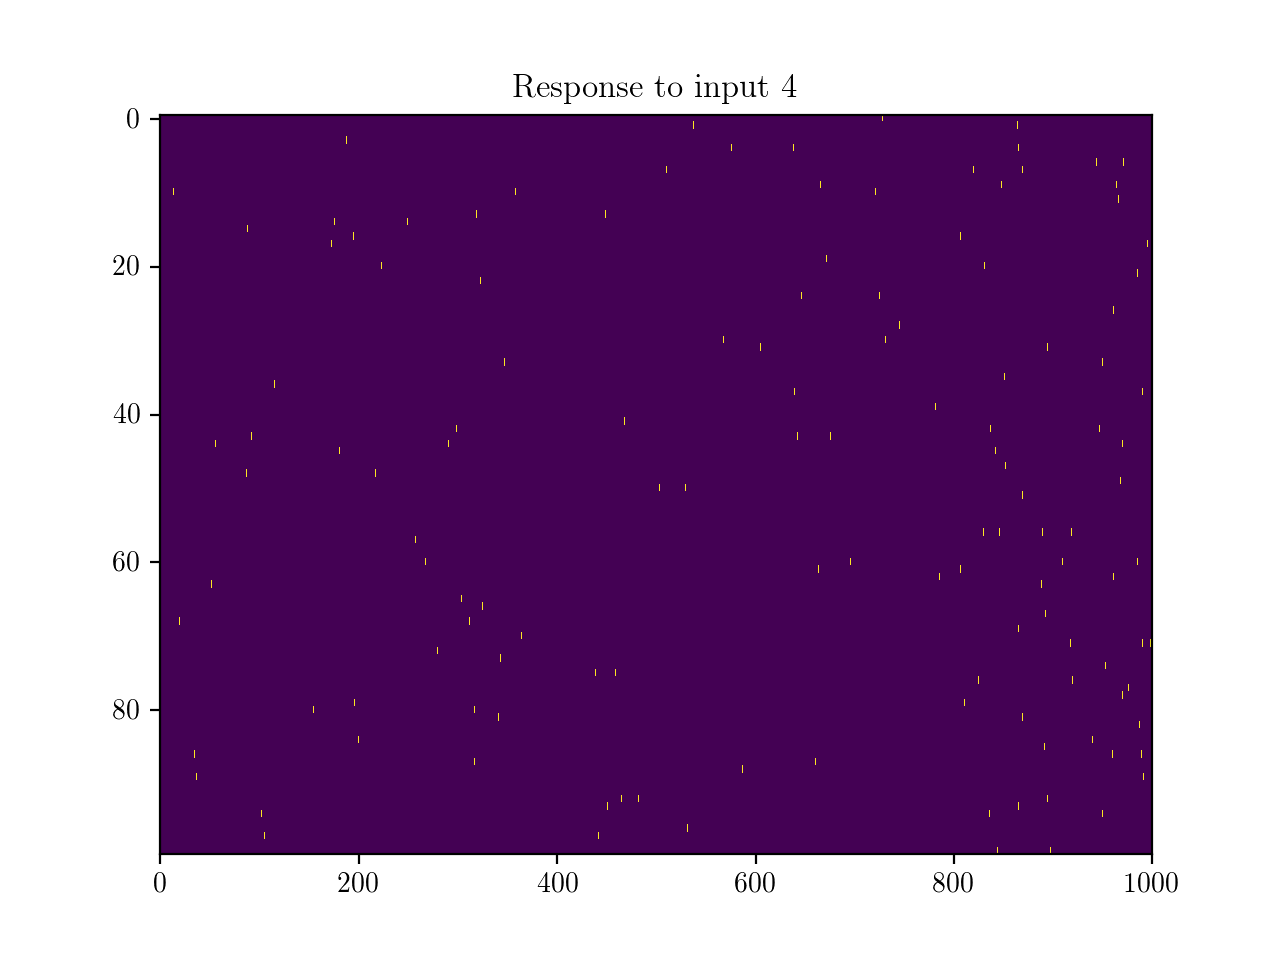

[False False False False  True False False False]


In [2]:
# Try reading it back....

metadata = requests.get("https://s3.nautilus.optiputer.net/braingeneers/simulated/timeseries/metadata.json").json()
dataset_train = metadata['train_examples_name']
dataset_test = metadata['test_examples_name']

def parse_one_example(example):
    example = tf.parse_single_example(example, features = {
        "example": tf.FixedLenFeature([], tf.string),
        "label": tf.FixedLenFeature([], tf.int64)
    })
    bits = tf.decode_raw(example['example'], tf.uint8)
    timeseries = np.unpackbits(bits).reshape((
        metadata['recording_time'], metadata['number_of_cells']))
    return timeseries, tf.one_hot(example["label"], len(metadata["labels"]))

training_dataset = tf.data.TFRecordDataset([dataset_train])
test_dataset = tf.data.TFRecordDataset([dataset_test])

# Extract and display first image
# https://www.tensorflow.org/api_guides/python/image#Encoding_and_Decoding
example, label = parse_one_example(training_dataset.make_one_shot_iterator().get_next())

plt.figure()
print(label.numpy().astype(np.bool))
plt.imshow(example, aspect='auto')
plt.title('Response to input {}'.format(np.array(metadata['labels'])[label.numpy().astype(np.bool)][0]))

# Bibliography

Izhikevich, E. M. (2003). Simple model of spiking neurons. _IEEE Transactions on neural networks_, 14(6), 1569-1572.
> This paper was the first publication using this neuron
> model, but it was later improved, and I only refer to
> the paper because it included a rather pretty demo,
> which I reproduced here.

Izhikevich, E. M. (2007). Dynamical systems in neuroscience. MIT press.
> This book is the best source of the computationally
> efficient neuron model I used (albeit not with as much
> physical explanation as I attempted to provide, but at
> least the units check out now), with demonstrations
> of how to tune the parameters to reproduce the behavior
> of actual cell types measured in vivo, as well as
> dynamical systems analyses of the resulting models.
> It's also a pretty good introduction to bifurcation theory!

Song, S., Sjöström, P. J., Reigl, M., Nelson, S., & Chklovskii, D. B. (2005). Highly nonrandom features of synaptic connectivity in local cortical circuits. _PLoS biology_, 3(3), e68.
> This paper describes the measured distribution of EPSPs
> generated by layer-V pyramidal cells in rat V1. I used
> its results as a guess as to the synaptic distribution
> in our organoids, under the assumption that "cortex is
> cortex", which is patently ridiculous. :) Eventually,
> The distribution will be modified by STDP and other
> forms of plasticity, making the prior less important.